# A Brief Introduction to Monte Carlo Event Generators

This part of the tutorial is primarily based on the article https://arxiv.org/pdf/1412.4677. 

In a similar way to the Monte Carlo integration that we have previously discussed, we can scan over a function $f(x)$, and "collect" phase-space points, along with their associated "probabilities", that are proportional to the weight of each in the calculation for the integral. These points effectively correspond to possible "events", with their weights corresponding to their probability of occurring. 

However, if we want to use these events, e.g. to perform an experimental analysis, then we must always carry the associated weight around for use in histograms, averages and so on. This can be inconvenient, but also very inefficient, as time may be wasted in some latter part of the simulation (e.g. a simulation of the effects of the detector) to events that possess only a very small weight. 

The "hit-or-miss" method aims to equalize the weights of different events as far as possible. 

Since the weight of each event is proportional to the probability of occurring, we can unweighted the events by keeping only a fraction of them, according to their weights. We do this by finding the maximum weight which occurs in the integration region, while we are performing the Monte Carlo integration. 

Let's do this for $f(x) = \sqrt{1-x^2}$:

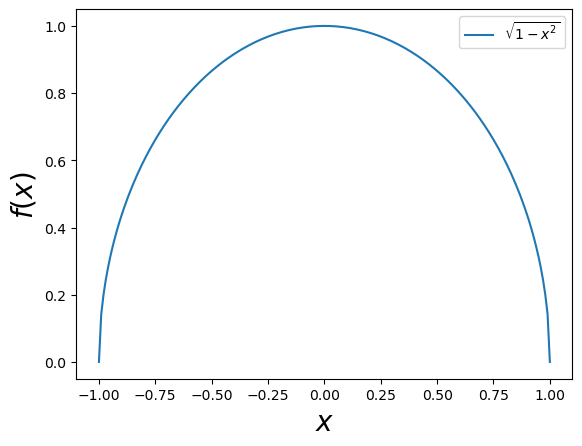

In [2]:
import matplotlib.pyplot as plt # import matplotlib, a conventional module name is plt
import numpy as np
from math import pi

x = np.linspace(-1, 1, 200) # creates a NumPy array from -1 to 1, 200 equallys-paced points  
y = np.sqrt(1-x**2) # take the NumPy array and create another one, where each term is now the sine of each of the elements of the above NumPy array

fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

# set the labels and titles:
ax.set_xlabel(r'$x$', fontsize=20) # set the x label
ax.set_ylabel(r'$f(x)$', fontsize=20) # set the y label. Note that the 'r' is necessary to remove the need for double slashes. You can use LaTeX! 

# make a one-dimensional plot using the above arrays, add a custom label
ax.plot(x, y, label=r'$\sqrt{1-x^2}$') 

# construct the legend:
ax.legend(loc='upper right')  # Add a legend

plt.show() # show the plot here

First let's write the integration function (as a solution to the exercise found in the ```MCintegration.ipynb``` notebook)

In [35]:
import math
import random

# Let's define a function that performs one-dimensional MC integration of an arbitrary for N points
# We'll also make it capable of performing the integration in an interval a,b
def mcint(func, a, b, N):
    """Calculates the one-dimensional Monte Carlo integral of func in [a,b] for N points"""
    sumw = 0 # we will use this variable for the sum of f(x_i)
    sumwsq = 0 # and this one for the sum of f(x_i)^2, used in the error calculation
    for i in range(int(N)):
        xi = (b-a) * random.random() + a
        wi = (b-a)*func(xi)
        sumw += wi
        sumwsq += wi**2 
    # now calculate the average value of f (i.e. the integral):
    I = sumw/N
    # and the error: 
    sigmaIsq = (1/N) * ( (1/N) * sumwsq - I**2 ) # this is the variance (i.e. the error squared)
    sigmaI = math.sqrt(sigmaIsq) # this is the actual error
    return I, sigmaI # return the integral and its error


And apply it: 

In [36]:
# Now let's also define the function that we wish to integrate:
def f(x):
    return np.sqrt(1-x**2)

# and use our mcint() function to integrate it in [0,1]:
N = 100000 # with 10000 points we expect O(1/sqrt(N)) ~ O(1%) error
Int, Err = mcint(f,-1,1,N) # this way you can access both the integral and its error

# print the results:
print("Analytic value of the integral=", math.pi/2)
print("The MC integral of f(x) = sqrt(1-x^2) in [-1,1] is", Int, "+-", Err)
print("The fractional uncertainty is", Err/Int)
print("The fractional difference from the analytical value is", abs(Int-math.pi/2)/(math.pi/2))

Analytic value of the integral= 1.5707963267948966
The MC integral of f(x) = sqrt(1-x^2) in [-1,1] is 1.5716439777676177 +- 0.0014114392890402468
The fractional uncertainty is 0.0008980655345653234
The fractional difference from the analytical value is 0.0005396313693008678


Now let's modify the function to also return the maximum value of $x$ and the maximum value of $f(x)$, as calculated numerically:

In [37]:
# Let's define a function that performs one-dimensional MC integration of an arbitrary for N points
# We'll also make it capable of performing the integration in an interval a,b
def mcint(func, a, b, N):
    """Calculates the one-dimensional Monte Carlo integral of func in [a,b] for N points"""
    sumw = 0 # we will use this variable for the sum of f(x_i)
    sumwsq = 0 # and this one for the sum of f(x_i)^2, used in the error calculation
    maxw = -1E99 # the maximum weight found during the integration
    xmaxw = -1E99 # the location of the maximum weight 
    for i in range(int(N)):
        xi = (b-a) * random.random() + a
        wi = (b-a)*func(xi)
        sumw += wi
        sumwsq += wi**2 
        if wi > maxw:
            maxw = wi
            xmaxw = xi
    # now calculate the average value of f (i.e. the integral):
    I = sumw/N
    # and the error: 
    sigmaIsq = (1/N) * ( (1/N) * sumwsq - I**2 ) # this is the variance (i.e. the error squared)
    sigmaI = math.sqrt(sigmaIsq) # this is the actual error
    return I, sigmaI, maxw, xmaxw # return the integral and its error and the maximum weight and its location

In [39]:
# Use the function again to get the integral and the maximum weight: 
N = 100000 # with 10000 points we expect O(1/sqrt(N)) ~ O(1%) error
Int, Err, MaxW, xMaxW = mcint(f,-1,1,N) # this way you can access both the integral and its error

print('Maximum weight found=', MaxW, 'at', xMaxW)

Maximum weight found= 1.9999999989149235 at -3.294049846180869e-05


This is as expected to be close to $=2$ at $x=0$, if enough points are used for the integral. 

Let's now see how to generate a sample of $x$'s  distributed according to $f(x) = \sqrt{1-x^2}$ (appropriately normalized). 

To proceed, we choose to keep ("accept") each $x$ (i.e. an "event"), with probability $w(x)/w_\mathrm{max})$, where $w(x)$ is the weight of the point and $w_\mathrm{max})$. The rest are thrown away ("rejected"). All accepted events are given a weight equal to the average weight $<w>$, used to calculate the integral. 

Let's try this with our given function, and compare to the expected (normalized) function. 

In [48]:
# event generation function according to func, given the number of events to be generated Ngen in the interval a, b,
# and number of integration events Nint
def evtgen(func, a, b, Ngen, Nint):
    # first find the integral using the integration function: 
    Int, Err, wmax, xwmax = mcint(func,a,b,Nint) 
    # define a counter to check when to terminate the event generation:
    counter = 0
    # an empty list to hold the Ngen events
    eventslist = []
    while counter < Ngen:
        # get a random point and calculate its weight: 
        xi = (b-a) * random.random() + a
        wi = (b-a)*func(xi)
        if wi/wmax > random.random():
            # accept the event, increment counter
            eventslist.append(xi)    
            counter += 1
        else:
            # reject the event and check another one
            continue 
    # return the integral, the eror and the events list
    return Int, Err, eventslist
    

Let's try it out!

In [49]:
# integral number of points:
Nintegral = 100000
# number of events to be generated: 
Nevents = 10000
sigma, sigmaerr, events = evtgen(f,-1,1,Nevents,Nintegral)

# check that the number of events generated is as requested:
print('Number of events generated=', len(events))

Number of events generated= 10000


And now let's compare the generated $x$'s to the normalized distribution: 

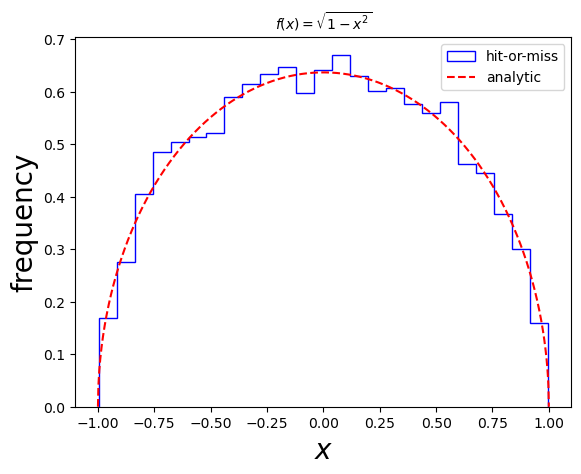

In [55]:
import matplotlib.pyplot as plt # import matplotlib, a conventional module name is plt
import numpy as np

fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

# set the labels and titles:
ax.set_xlabel(r'$x$', fontsize=20) # set the x label
ax.set_ylabel(r'frequency', fontsize=20) # set the y label
ax.set_title(r'$f(x)=\sqrt{1-x^2}$', fontsize=10) # set the title 

# make one-dimensional plots using the above arrays, add a custom label, linestyles and colors:
ax.hist(events, color='blue', bins=25, density=True, fill=False, histtype='step', label="hit-or-miss") 

# plot the distribution itself:
xv = np.linspace(-1, 1,1000)
gaussianpoints = f(xv) / (np.pi/2) # pi/2 is the analytic integral 

ax.plot(xv, gaussianpoints, ls='--', color='red', label='analytic')

# construct the legend:
ax.legend(loc='upper right')  # Add a legend

plt.show() # show the plot here

We are now ready to proceed to the particle physics case!